# Modèle de prédiction, Forêts aléatoires

Reprise du nb_v3.ipynb, mais sans tous les détails:

- sans l'exploration et la description complète des données (il faut consulter le nb_v3.ipynb) et
- sans le *scaling* des données pour alimenter le modèle binomial du nb_v3.ipynb.

Le modèle binomial du nb_v3.ipynb est repris dans le nb_v4.ipynb sous le nom de Modèle 1 (sans *scaling* ou standardisation). Vient s'ajouter un modèle multinomial sous le nom de Modèle 2 (sans *scaling* aussi). La standardisation des données est facultative avec les Random Forests; ces derniers ne sont pas sujets au sur-apprentissage comme le révèle le nb_v3.ipynb. Par contre, à des fins de comparaison avec d'autres sortes d'algorithmes de classification plus sujets au sur-apprentissage (régression logistique ou arbre de décision, par exemple), il vaut mieux standardiser le jeu de données qui alimentera tous les algorithmes de classification.

## Section 2b

### Analyse et exploration des données

#### Données nettoyées

In [1]:
import numpy as np
import pandas as pd

# Importer le données nettoyées
data: pd.DataFrame \
    = pd.read_pickle('data/ObesityDataSet_raw_and_data_sinthetic2.pkl')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Gender                   2111 non-null   category
 1   Gender_n                 2111 non-null   int8    
 2   Age                      2111 non-null   float16 
 3   Height                   2111 non-null   float16 
 4   Weight                   2111 non-null   float16 
 5   FHWO                     2111 non-null   category
 6   FHWO_n                   2111 non-null   int8    
 7   FAVC                     2111 non-null   category
 8   FAVC_n                   2111 non-null   int8    
 9   FCVC                     2111 non-null   category
 10  FCVC_n                   2111 non-null   int8    
 11  NCP                      2111 non-null   category
 12  NCP_n                    2111 non-null   int8    
 13  CAEC                     2111 non-null   category
 14  CAEC_n  

#### Description des données

Note: les features avec le suffixe _n sont les équivalents numériques des features d'origine.

- Gender: Genre;
    - ['Female', 'Male'] équivaut  [0, 1]
- Age: Âge;
    - continue
- Height: Taille, en mètres;
    - continue
- Weight: Masse, en kilogrammes;
    - continue
- FHWO: Famille souffrant ou ayant souffert d'obésité;
    - ['no', 'yes'] équivaut à [0, 1]
- FAVC: Haute fréquence de consommation d'aliments hypercaloriques;
    - ['no', 'yes'] équivaut à [0, 1]
- FCVC: Consommation de légumes avec les repas;
    - ['never', 'sometimes', 'always'] équivaut à [0, 1, 2]
- NCP: Nombre quotidien de repas;
    - ['1', '2', '3', '4+'] équivaut à [1, 2, 3, 4]
- CAEC: Collations entre les repas; 
    - ['no', 'Sometimes', 'Frequently', 'Always'] équivaut à [0, 1, 2, 3]
- SMOKE: Tabagisme;
    - ['no', 'yes'] équivaut à [0, 1]
- CH2O: Consommation quotidienne d'eau;
    - ['less_than_a_liter', '1–2_liters', 'more_than_2_liters'] équivaut à [1, 2, 3]
- SCC: Surveillance de sa consommation calorique;
    - ['no', 'yes'] équivaut à [0, 1]
- FAF: Fréquence d'activités physiques;
    - ['none', '1_to_2_days', '2_to_4_days', '4_to_5_days'] équivaut à [0, 1, 2, 3]
- TUE: Temps quotidien d'utilisation d'appareils (mobile, jeux vidéo, TV, ordinateur, etc.);
    - ['0–2_hours', '3–5_hours', 'more_than_5_hours'] équivaut à [1, 2, 3]
- CALC: Consommation d'alcool;
    - ['no', 'Sometimes', 'Frequently', 'Always'] équivaut à [0, 1, 2, 3]
- MTRANS: Transport le plus utilisé;
    - ['Automobile', 'Motorbike', 'Bike', 'Public_Transportation', 'Walking'] équivaut aux features
    - Automobile_n
    - Motorbike_n
    - Bike_n
    - Public_Transportation_n
    - Walking_n, tous faits de [0, 1]
- NObeyesdad: Niveau d'obésité;
    - ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'] équivaut à [1, 2, 3, 4, 5, 6, 7]
- NObeyesdad2: Niveau d'obésité;
    - ['not_obese', 'obese'] équivaut à [0, 1]

In [2]:
# Extraire les statistiques des features numériques
# avec des données catégoriques rendues numériques
data.describe(include=['int8', 'float16']).round(1)

,Gender_n,Age,Height,Weight,FHWO_n,FAVC_n,FCVC_n,NCP_n,CAEC_n,SMOKE_n,...,FAF_n,TUE_n,CALC_n,Automobile_n,Motorbike_n,Bike_n,Public_Transportation_n,Walking_n,NObeyesdad_n,NObeyesdad_n2
count,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0,...,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0,2111.0
mean,0.5,24.3,1.7,inf,0.8,0.9,1.4,2.7,1.1,0.0,...,1.0,1.7,0.7,0.2,0.0,0.0,0.7,0.0,4.1,0.5
std,0.5,6.3,0.1,26.2,0.4,0.3,0.6,0.8,0.5,0.1,...,0.9,0.7,0.5,0.4,0.1,0.1,0.4,0.2,2.0,0.5
min,0.0,14.0,1.5,39.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25%,0.0,20.0,1.6,65.5,1.0,1.0,1.0,3.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
50%,1.0,22.8,1.7,83.0,1.0,1.0,1.0,3.0,1.0,0.0,...,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0
75%,1.0,26.0,1.8,107.4,1.0,1.0,2.0,3.0,1.0,0.0,...,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,6.0,1.0
max,1.0,61.0,2.0,173.0,1.0,1.0,2.0,4.0,3.0,1.0,...,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,7.0,1.0


Difficile d'analyser autant de résultats...

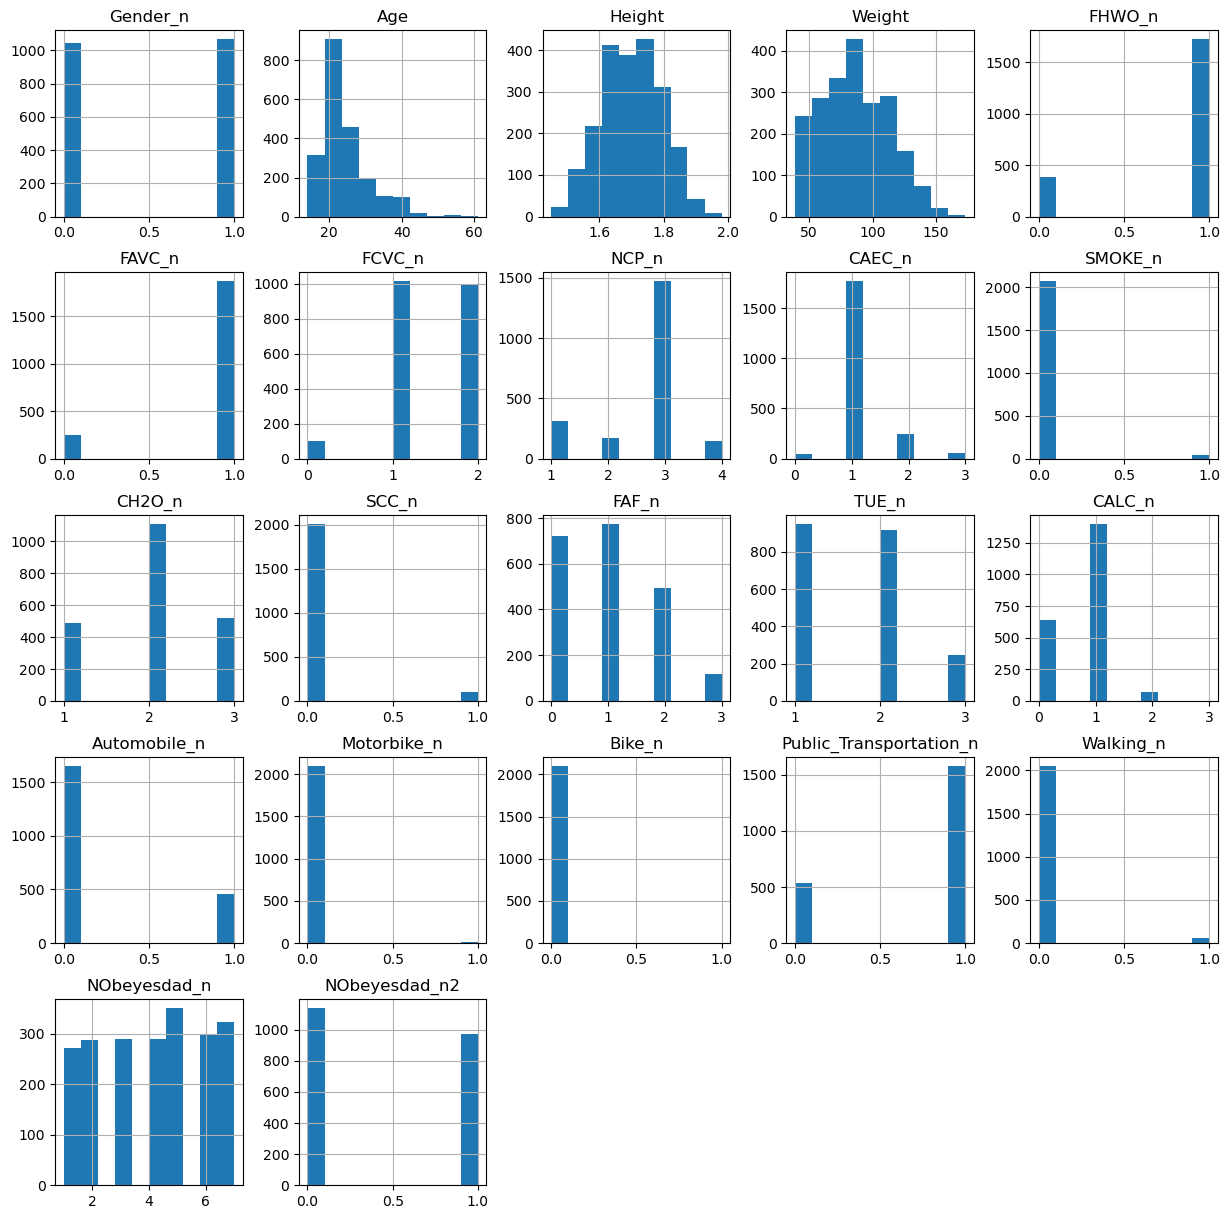

In [3]:
import matplotlib.pyplot as plt

# Afficher les histogrammes des features numériques
data.hist(figsize=(15, 15))
plt.show();

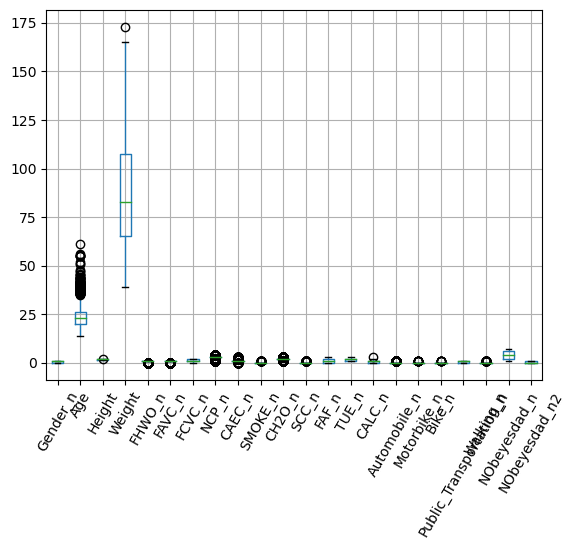

In [4]:
# Afficher les boites des features numériques
data.boxplot(rot=60)
plt.show();

Cette dernière vue montre qu'il n'y a pas de valeurs extrêmes ni de valeurs négatives (qui seraient insensées).

Par contre, les cercles illustrent des outliers selon la formule de Tukey. À la lumière des valeurs observées, il faut considérer ces "outliers" avec un grain de sel.

De retour aux histogrammes, les features qui ont été rendues numériques ne suivent pas la loi normale. Ce sont des distributions plutôt uniformes parce que ce sont des catégories.

Seuls Age et, surtout, Height sont des distributions normales. Ce sont des données numériques. 

Dans les données catégoriques, selon la matrice des histogrammes, les catégories ne sont pas équilibrées.

Gender et les colonnes NObeyesdad montrent des classes presque égales.

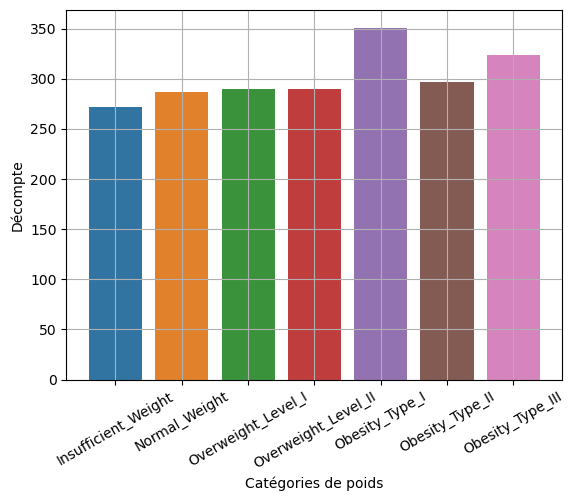

In [5]:
import seaborn as sns

# Explorer le nombre de répondants par catégorie de poids
# Seaborn fournit des graphiques pour les données catégoriques
# Consulter:
# https://seaborn.pydata.org/generated/seaborn.catplot.html
# https://seaborn.pydata.org/generated/seaborn.countplot.html
sns.countplot(data=data, x='NObeyesdad')
plt.xticks(rotation=30)
plt.xlabel("Catégories de poids")
plt.ylabel("Décompte")
plt.grid()
plt.plot();

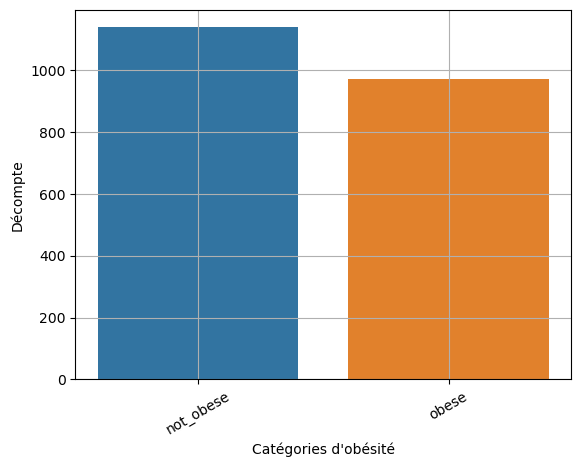

In [6]:
# Explorer le nombre de répondants par catégorie de poids
sns.countplot(data=data, x='NObeyesdad2')
plt.xticks(rotation=30)
plt.xlabel("Catégories d'obésité")
plt.ylabel("Décompte")
plt.grid()
plt.plot();

En terme de nombre de répondants, aucune des catégories de poids n'est largement supérieure à une autre.

Ce qui donne une quantité équilibrée d'observations par catégorie pour entrainer un modèle de classification.

Les autres features montrent des classes inégales. Par exemple, il y a un net déséquilibre dans SMOKE (fumeur ou non-fumeur).

Il faudrait un meilleur échantillon et plus d'observations pour arriver à un meilleur équilibre des classes ou de chaque catégorie dans chaque features.

### Hypothèses (1 de 2)

In [7]:
# On a donc une cible (y) de catégories binaires
data['NObeyesdad2'].cat.categories

Index(['not_obese', 'obese'], dtype='object')

In [8]:
data['NObeyesdad_n2'].unique()

array([0, 1], dtype=int8)

In [9]:
# Vérifier la concordance
data[['NObeyesdad2', 'NObeyesdad_n2']].loc[data['NObeyesdad_n2'] == 0].head(2)

,NObeyesdad2,NObeyesdad_n2
0,not_obese,0
1,not_obese,0


In [10]:
data[['NObeyesdad2', 'NObeyesdad_n2']].loc[data['NObeyesdad_n2'] == 1].head(2)

,NObeyesdad2,NObeyesdad_n2
10,obese,1
13,obese,1


Ce qui permet de faire une classification binomiale avec les autres features (X): c'est le Modèle 1.

In [11]:
# On a aussi une cible (y) de catégories multiples
data['NObeyesdad'].cat.categories

Index(['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
       'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II',
       'Obesity_Type_III'],
      dtype='object')

In [12]:
data['NObeyesdad_n'].unique()

array([2, 3, 4, 5, 1, 6, 7], dtype=int8)

In [13]:
# Vérifier la concordance
# not_obese
data[['NObeyesdad', 'NObeyesdad_n']].loc[data['NObeyesdad_n'] == 1].head(2)

,NObeyesdad,NObeyesdad_n
59,Insufficient_Weight,1
71,Insufficient_Weight,1


In [14]:
data[['NObeyesdad', 'NObeyesdad_n']].loc[data['NObeyesdad_n'] == 2].head(2)

,NObeyesdad,NObeyesdad_n
0,Normal_Weight,2
1,Normal_Weight,2


In [15]:
data[['NObeyesdad', 'NObeyesdad_n']].loc[data['NObeyesdad_n'] == 3].head(2)

,NObeyesdad,NObeyesdad_n
3,Overweight_Level_I,3
19,Overweight_Level_I,3


In [16]:
data[['NObeyesdad', 'NObeyesdad_n']].loc[data['NObeyesdad_n'] == 4].head(2)

,NObeyesdad,NObeyesdad_n
4,Overweight_Level_II,4
11,Overweight_Level_II,4


In [17]:
# obese
data[['NObeyesdad', 'NObeyesdad_n']].loc[data['NObeyesdad_n'] == 5].head(2)

,NObeyesdad,NObeyesdad_n
10,Obesity_Type_I,5
13,Obesity_Type_I,5


In [18]:
data[['NObeyesdad', 'NObeyesdad_n']].loc[data['NObeyesdad_n'] == 6].head(2)

,NObeyesdad,NObeyesdad_n
68,Obesity_Type_II,6
90,Obesity_Type_II,6


In [19]:
data[['NObeyesdad', 'NObeyesdad_n']].loc[data['NObeyesdad_n'] == 7].head(2)

,NObeyesdad,NObeyesdad_n
202,Obesity_Type_III,7
344,Obesity_Type_III,7


Ce qui permet de faire une classification multinomiale avec les autres features (X): c'est le Modèle 2.

### Modèle 1: optimisation (3 de 5)

#### Préparation des jeux d'entrainement et de test

In [20]:
from typing import List  # pour le typing

# Choisir les features numériques
cols: List[str] \
    = ['Gender_n', 'Age', 'Height', 'FHWO_n', 'FAVC_n', 'FCVC_n',
       'NCP_n', 'CAEC_n', 'SMOKE_n', 'CH2O_n', 'SCC_n', 'FAF_n',
       'TUE_n', 'CALC_n', 'Automobile_n', 'Motorbike_n', 'Bike_n',
       'Public_Transportation_n', 'Walking_n',
       'NObeyesdad_n', 'NObeyesdad_n2']

# Appliquer
data4: pd.DataFrame \
    = data[cols]

data4.head(3)

,Gender_n,Age,Height,FHWO_n,FAVC_n,FCVC_n,NCP_n,CAEC_n,SMOKE_n,CH2O_n,...,FAF_n,TUE_n,CALC_n,Automobile_n,Motorbike_n,Bike_n,Public_Transportation_n,Walking_n,NObeyesdad_n,NObeyesdad_n2
0,0,21.0,1.620117,1,0,1,3,1,0,2,...,0,2,0,0,0,0,1,0,2,0
1,0,21.0,1.519531,1,0,2,3,1,1,3,...,3,1,1,0,0,0,1,0,2,0
2,1,23.0,1.799805,1,0,1,3,1,0,2,...,2,2,2,0,0,0,1,0,2,0


In [21]:
# Créer la matrice de features avec toutes les colonnes sauf les 4 dernières
data4.columns.values

array(['Gender_n', 'Age', 'Height', 'FHWO_n', 'FAVC_n', 'FCVC_n', 'NCP_n',
       'CAEC_n', 'SMOKE_n', 'CH2O_n', 'SCC_n', 'FAF_n', 'TUE_n', 'CALC_n',
       'Automobile_n', 'Motorbike_n', 'Bike_n', 'Public_Transportation_n',
       'Walking_n', 'NObeyesdad_n', 'NObeyesdad_n2'], dtype=object)

In [22]:
X: pd.DataFrame \
    = data4.iloc[:, :-2]

In [23]:
# Créer le vecteur cible avec la dernière colonne
y: pd.Series \
    = data4.iloc[:, -1]

In [24]:
# Vérifier la taille des objets
data4.shape, X.shape, y.shape

((2111, 21), (2111, 19), (2111,))

In [25]:
from sklearn.model_selection import train_test_split

# Scinder le jeu de données: 80/20
# random_state est expliqué plus loin...
X_train: np.ndarray
X_test: np.ndarray
y_train: np.ndarray
y_test: np.ndarray
X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.20,
                       random_state=0)

In [26]:
# Vérifier la taille des objets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1688, 19), (1688,), (423, 19), (423,))

#### Exécution

In [27]:
import sklearn  # pour le typing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Estimer un scénario avec
# 135 estimateurs et
# la séquence pseudo-aléatoire 0
# Extraire les scores de justesse
rfc: sklearn.ensemble \
    = RandomForestClassifier(n_estimators=135,
                             random_state=0)

rfc.fit(X_train, y_train)

rf_y_pred: np.ndarray \
    = rfc.predict(X_test)

rf_scores: float \
    = accuracy_score(y_test, rf_y_pred)
print(f"Score de justesse (accuracy score): {round(rf_scores, 3)}")

Score de justesse (accuracy score): 0.941


In [28]:
# Calculer l'importance des features qui expliquent l'obésité
# en ordre décroissant
rf_feature_importance: pd.Series = pd.Series(rfc.feature_importances_,
                                             index=X.columns).sort_values(
                                             ascending=False)
print(f"Importance:\n{rf_feature_importance.round(3)}")

Importance:
Age                        0.203
Height                     0.161
FHWO_n                     0.111
NCP_n                      0.075
CAEC_n                     0.069
CALC_n                     0.052
FAF_n                      0.051
FAVC_n                     0.051
FCVC_n                     0.044
Gender_n                   0.043
CH2O_n                     0.041
TUE_n                      0.034
Public_Transportation_n    0.024
Automobile_n               0.019
SCC_n                      0.010
Walking_n                  0.006
SMOKE_n                    0.005
Motorbike_n                0.002
Bike_n                     0.000
dtype: float64


Les features avec le suffixe _n sont les équivalents numériques des features originaux

- Gender: Genre;
    - ['Female', 'Male'] équivaut  [0, 1]
- Age: Âge;
    - continue
- Height: Taille, en mètres;
    - continue
- Weight: Masse, en kilogrammes;
    - continue
- FHWO: Famille souffrant ou ayant souffert d'obésité;
    - ['no', 'yes'] équivaut à [0, 1]
- FAVC: Haute fréquence de consommation d'aliments hypercaloriques;
    - ['no', 'yes'] équivaut à [0, 1]
- FCVC: Consommation de légumes avec les repas;
    - ['never', 'sometimes', 'always'] équivaut à [0, 1, 2]
- NCP: Nombre quotidien de repas;
    - ['1', '2', '3', '4+'] équivaut à [1, 2, 3, 4]
- CAEC: Collations entre les repas; 
    - ['no', 'Sometimes', 'Frequently', 'Always'] équivaut à [0, 1, 2, 3]
- SMOKE: Tabagisme;
    - ['no', 'yes'] équivaut à [0, 1]
- CH2O: Consommation quotidienne d'eau;
    - ['less_than_a_liter', '1–2_liters', 'more_than_2_liters'] équivaut à [1, 2, 3]
- SCC: Surveillance de sa consommation calorique;
    - ['no', 'yes'] équivaut à [0, 1]
- FAF: Fréquence d'activités physiques;
    - ['none', '1_to_2_days', '2_to_4_days', '4_to_5_days'] équivaut à [0, 1, 2, 3]
- TUE: Temps quotidien d'utilisation d'appareils (mobile, jeux vidéo, TV, ordinateur, etc.);
    - ['0–2_hours', '3–5_hours', 'more_than_5_hours'] équivaut à [1, 2, 3]
- CALC: Consommation d'alcool;
    - ['no', 'Sometimes', 'Frequently', 'Always'] équivaut à [0, 1, 2, 3]
- MTRANS: Transport le plus utilisé;
    - ['Automobile', 'Motorbike', 'Bike', 'Public_Transportation', 'Walking'] équivaut aux features
    - Automobile_n
    - Motorbike_n
    - Bike_n
    - Public_Transportation_n
    - Walking_n, tous faits de [0, 1]
- NObeyesdad: Niveau d'obésité;
    - ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'] équivaut à [1, 2, 3, 4, 5, 6, 7]
- NObeyesdad2: Niveau d'obésité;
    - ['not_obese', 'obese'] équivaut à [0, 1]

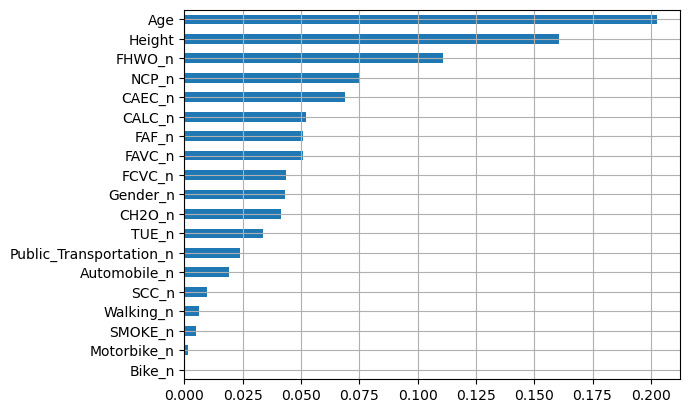

In [29]:
# Visualiser en ordre décroissant
rf_feature_importance.sort_values(ascending=True).plot.barh()
plt.grid()
plt.show();

In [30]:
# Extraire les 5 plus importantes features qui expliquent l'obésité
print(f"Importance (Top 5):\n{rf_feature_importance.iloc[:5].round(3)}")

Importance (Top 5):
Age       0.203
Height    0.161
FHWO_n    0.111
NCP_n     0.075
CAEC_n    0.069
dtype: float64


Les facteurs qui déterminent l'obésité sont:

- Age: Âge;
    - continue
    - En utilisant le modèle, prédiction démontrent que ce feature est très influent sur le résultat (0 ou 1); au point même où ce feature "écrase" les autres feature
- Height: Taille, en mètres;
    - continue
- FHWO: Famille souffrant ou ayant souffert d'obésité;
- NCP: Nombre quotidien de repas;
    - ['1', '2', '3', '4+'] équivaut à [1, 2, 3, 4]
- CAEC: Collations entre les repas; 
    - ['no', 'Sometimes', 'Frequently', 'Always'] équivaut à [0, 1, 2, 3]

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculer la matrice de confusion
cm: np.ndarray \
    = confusion_matrix(y_test, rf_y_pred, labels=rfc.classes_)
cm

array([[219,  15],
       [ 10, 179]], dtype=int64)

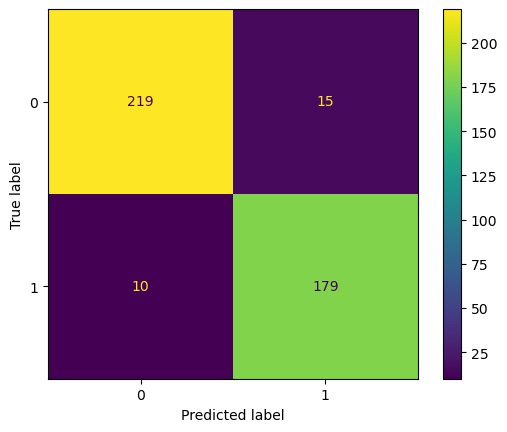

In [32]:
# La matrice montre les vrais positifs et négatifs sur la diagonale
# gauche-droite-haut-bas
# Consulter:
# https://fr.wikipedia.org/wiki/Matrice_de_confusion

# Visualiser la matrice de confusion
disp: sklearn.metrics \
    = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rfc.classes_)
disp.plot()
plt.show();

In [33]:
# Un bon modèle maximise les vrais positifs et négatifs

from sklearn.metrics import classification_report

# C'est cette matrice qui permet de calculer la justesse et
# d'autres métriques

# Les métrique se résument à
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       234
           1       0.92      0.95      0.93       189

    accuracy                           0.94       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.94      0.94      0.94       423



In [34]:
# On remarque la justesse
print(f"Score de justesse (accuracy score): {round(rf_scores, 2)}")

Score de justesse (accuracy score): 0.94


La totalité des métriques et leurs définitions.

Consulter:

- https://scikit-learn.org/stable/modules/model_evaluation.html?highlight=precision+recall+f1
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html?highlight=auc

In [35]:
# Rappeler l'algorithme qui a été entrainé
rfc

RandomForestClassifier(n_estimators=135, random_state=0)

In [36]:
import joblib

# Créer le dossier modele avec le gestionnaire du PC

# Sauvegarder l'algorithme dans un fichier Pickle
joblib.dump(rfc, 'modele/modele_1_rf.pkl')

['modele/modele_1_rf.pkl']

### Modèle 2 : prédiction et résolution (2 de 5)

#### Préparation des jeux d'entrainement et de test

In [37]:
# Créer la matrice de features avec toutes les colonnes sauf les 4 dernières
data4.columns.values

array(['Gender_n', 'Age', 'Height', 'FHWO_n', 'FAVC_n', 'FCVC_n', 'NCP_n',
       'CAEC_n', 'SMOKE_n', 'CH2O_n', 'SCC_n', 'FAF_n', 'TUE_n', 'CALC_n',
       'Automobile_n', 'Motorbike_n', 'Bike_n', 'Public_Transportation_n',
       'Walking_n', 'NObeyesdad_n', 'NObeyesdad_n2'], dtype=object)

In [38]:
X: pd.DataFrame \
    = data4.iloc[:, :-2]

In [39]:
# Créer le vecteur cible avec l'avant-dernière colonne
y: pd.Series \
    = data4.iloc[:, -2]

In [40]:
# Vérifier la taille des objets
data4.shape, X.shape, y.shape

((2111, 21), (2111, 19), (2111,))

In [41]:
from sklearn.model_selection import train_test_split

# Scinder le jeu de données: 80/20
# random_state est expliqué plus loin...
X_train: np.ndarray
X_test: np.ndarray
y_train: np.ndarray
y_test: np.ndarray
X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.20,
                       random_state=0)

In [42]:
# Vérifier la taille des objets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1688, 19), (1688,), (423, 19), (423,))

#### Exécution

#### Plusieurs scénarios

Le modèle des FA est très riche. On peut déterminer le nombre d'estimateurs (l'hyperparamètre principal). Chaque estimateur est un arbre de décision. Un modèle peut donc se baser sur 1, 10, 100, 500 arbres de décisions.

Cependant, le critère principal est de trouver un modèle suffisamment juste. Parmi tous les modèles possibles, le 2e critère, après la justesse, est de trouver un modèle qui requiert le moins de temps de calcul.

In [43]:
# Varier le nombre d'estimateurs (n_estimators)
# (calcul long!)
rf_scores: float \
    = []

for k in range(1, 400):
    rfc: sklearn.ensemble \
        = RandomForestClassifier(n_estimators=k)
    rfc.fit(X_train, y_train)
    rf_y_pred: np.ndarray \
        = rfc.predict(X_test)
    rf_scores.append(accuracy_score(y_test, rf_y_pred))

In [44]:
# Extraire les scores de justesse
print(f"Scores de justesse (accuracy score):\n"
      f"{np.array(rf_scores).round(3)}")

Scores de justesse (accuracy score):
[0.695 0.733 0.754 0.799 0.78  0.794 0.813 0.801 0.823 0.835 0.813 0.835
 0.835 0.827 0.835 0.832 0.82  0.827 0.844 0.842 0.827 0.823 0.823 0.83
 0.827 0.83  0.856 0.842 0.842 0.827 0.844 0.835 0.844 0.837 0.832 0.832
 0.832 0.83  0.846 0.837 0.827 0.842 0.858 0.837 0.839 0.837 0.835 0.846
 0.844 0.83  0.832 0.856 0.839 0.816 0.844 0.846 0.844 0.839 0.837 0.842
 0.837 0.851 0.839 0.837 0.861 0.83  0.83  0.844 0.851 0.851 0.839 0.82
 0.83  0.839 0.858 0.837 0.832 0.839 0.839 0.837 0.849 0.842 0.835 0.851
 0.849 0.835 0.851 0.83  0.83  0.832 0.83  0.842 0.835 0.827 0.837 0.835
 0.851 0.83  0.849 0.837 0.844 0.839 0.835 0.844 0.835 0.842 0.844 0.844
 0.849 0.842 0.825 0.832 0.839 0.837 0.851 0.835 0.832 0.844 0.842 0.839
 0.825 0.835 0.835 0.842 0.839 0.846 0.837 0.837 0.844 0.835 0.832 0.844
 0.825 0.844 0.849 0.832 0.839 0.839 0.837 0.853 0.849 0.844 0.853 0.83
 0.851 0.839 0.837 0.846 0.837 0.842 0.839 0.839 0.83  0.853 0.842 0.835
 0.844 0.842 0.85

#### Visualisation des résultats (2 de 5)

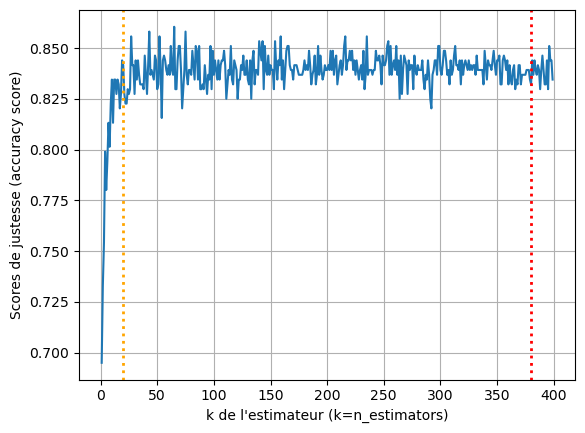

In [45]:
# Visualiser les scores de justesse
plt.plot(range(1, len(rf_scores)+1), rf_scores)
plt.xlabel("k de l'estimateur (k=n_estimators)")
plt.ylabel("Scores de justesse (accuracy score)")
plt.axvline(20, color='orange', linestyle='dotted', linewidth=2, label='k=20')
plt.axvline(380, color='red', linestyle='dotted', linewidth=2, label='k=380')
plt.grid()
plt.show();

La justesse du modèle s'améliore rapidement entre 1 et 20 estimateurs, puis ralentit autour de 20 estimateurs, la justesse plafonne, mais reste volatile d'un incrément à un autre.

Vers 380 estimateurs, la justesse se stabilise (moins de volatilité entre les incréments).

380 estimateurs semble un nombre optimal qui maximise la justesse et minimise le temps de calcul.

Cependant, il faut tester avec 380, 400, 450 et plus estimateurs pour constater les résultats.

### Modèle: optimisation (3 de 5)

#### Exécution

In [46]:
# Estimer un scénario avec
# 400 estimateurs et
# la séquence pseudo-aléatoire 0
# Extraire les scores de justesse
rfc: sklearn.ensemble \
    = RandomForestClassifier(n_estimators=400,
                             random_state=0)

rfc.fit(X_train, y_train)

rf_y_pred: np.ndarray \
    = rfc.predict(X_test)

rf_scores: float \
    = accuracy_score(y_test, rf_y_pred)
print(f"Score de justesse (accuracy score): {round(rf_scores, 3)}")

Score de justesse (accuracy score): 0.842


In [47]:
# Calculer l'importance des features qui expliquent l'obésité
# en ordre décroissant
rf_feature_importance: pd.Series = pd.Series(rfc.feature_importances_,
                                             index=X.columns).sort_values(
                                             ascending=False)
print(f"Importance:\n{rf_feature_importance.round(3)}")

Importance:
Age                        0.192
Height                     0.167
NCP_n                      0.069
Gender_n                   0.067
FCVC_n                     0.066
CALC_n                     0.065
FAF_n                      0.060
CAEC_n                     0.056
FHWO_n                     0.056
TUE_n                      0.048
CH2O_n                     0.046
FAVC_n                     0.030
Public_Transportation_n    0.029
Automobile_n               0.024
SCC_n                      0.011
Walking_n                  0.007
SMOKE_n                    0.004
Motorbike_n                0.001
Bike_n                     0.001
dtype: float64


Les features avec le suffixe _n sont les équivalents numériques des features originaux

- Gender: Genre;
    - ['Female', 'Male'] équivaut  [0, 1]
- Age: Âge;
    - continue
- Height: Taille, en mètres;
    - continue
- Weight: Masse, en kilogrammes;
    - continue
- FHWO: Famille souffrant ou ayant souffert d'obésité;
    - ['no', 'yes'] équivaut à [0, 1]
- FAVC: Haute fréquence de consommation d'aliments hypercaloriques;
    - ['no', 'yes'] équivaut à [0, 1]
- FCVC: Consommation de légumes avec les repas;
    - ['never', 'sometimes', 'always'] équivaut à [0, 1, 2]
- NCP: Nombre quotidien de repas;
    - ['1', '2', '3', '4+'] équivaut à [1, 2, 3, 4]
- CAEC: Collations entre les repas; 
    - ['no', 'Sometimes', 'Frequently', 'Always'] équivaut à [0, 1, 2, 3]
- SMOKE: Tabagisme;
    - ['no', 'yes'] équivaut à [0, 1]
- CH2O: Consommation quotidienne d'eau;
    - ['less_than_a_liter', '1–2_liters', 'more_than_2_liters'] équivaut à [1, 2, 3]
- SCC: Surveillance de sa consommation calorique;
    - ['no', 'yes'] équivaut à [0, 1]
- FAF: Fréquence d'activités physiques;
    - ['none', '1_to_2_days', '2_to_4_days', '4_to_5_days'] équivaut à [0, 1, 2, 3]
- TUE: Temps quotidien d'utilisation d'appareils (mobile, jeux vidéo, TV, ordinateur, etc.);
    - ['0–2_hours', '3–5_hours', 'more_than_5_hours'] équivaut à [1, 2, 3]
- CALC: Consommation d'alcool;
    - ['no', 'Sometimes', 'Frequently', 'Always'] équivaut à [0, 1, 2, 3]
- MTRANS: Transport le plus utilisé;
    - ['Automobile', 'Motorbike', 'Bike', 'Public_Transportation', 'Walking'] équivaut aux features
    - Automobile_n
    - Motorbike_n
    - Bike_n
    - Public_Transportation_n
    - Walking_n, tous faits de [0, 1]
- NObeyesdad: Niveau d'obésité;
    - ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'] équivaut à [1, 2, 3, 4, 5, 6, 7]
- NObeyesdad2: Niveau d'obésité;
    - ['not_obese', 'obese'] équivaut à [0, 1]

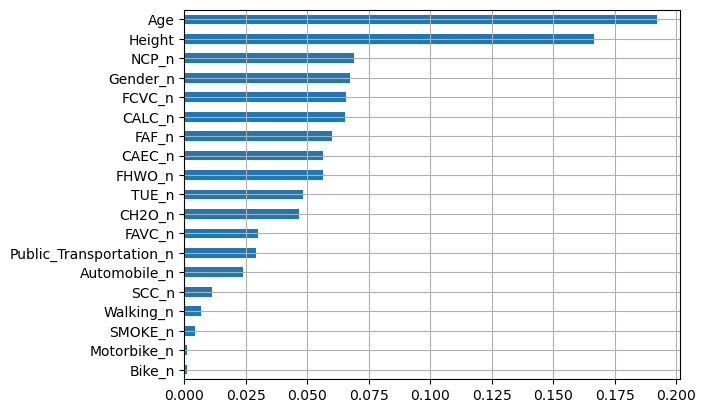

In [48]:
# Visualiser en ordre décroissant
rf_feature_importance.sort_values(ascending=True).plot.barh()
plt.grid()
plt.show();

In [49]:
# Extraire les 5 plus importantes features qui expliquent l'obésité
print(f"Importance (Top 5):\n{rf_feature_importance.iloc[:5].round(3)}")

Importance (Top 5):
Age         0.192
Height      0.167
NCP_n       0.069
Gender_n    0.067
FCVC_n      0.066
dtype: float64


Les facteurs qui déterminent l'obésité sont:

- Age: Âge;
    - continue
    - En utilisant le modèle, prédiction démontrent que ce feature est très influent sur le résultat (0 ou 1); au point même où ce feature "écrase" les autres feature
- Height: Taille, en mètres;
    - continue
- NCP: Nombre quotidien de repas;
    - ['1', '2', '3', '4+'] équivaut à [1, 2, 3, 4]
- Gender: Genre;
    - ['Female', 'Male'] équivaut  [0, 1]
- FCVC: Consommation de légumes avec les repas;
    - ['never', 'sometimes', 'always'] équivaut à [0, 1, 2]

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculer la matrice de confusion
cm: np.ndarray \
    = confusion_matrix(y_test, rf_y_pred, labels=rfc.classes_)
cm

array([[58,  5,  0,  1,  1,  0,  0],
       [ 7, 39,  3,  3,  4,  1,  0],
       [ 1,  5, 44,  2,  4,  0,  1],
       [ 3,  5,  2, 39,  1,  5,  0],
       [ 1,  2,  2,  4, 55,  2,  1],
       [ 0,  0,  0,  1,  0, 52,  0],
       [ 0,  0,  0,  0,  0,  0, 69]], dtype=int64)

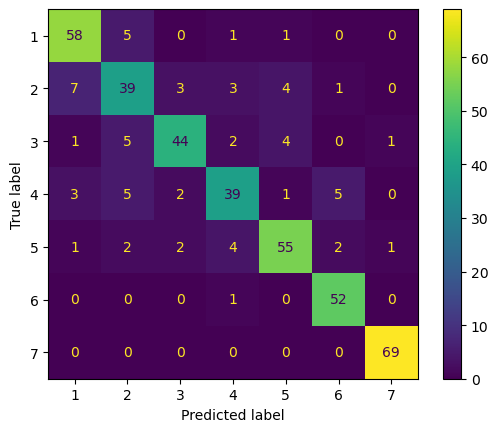

In [51]:
# La matrice montre les vrais positifs et négatifs sur la diagonale
# gauche-droite-haut-bas
# Consulter:
# https://fr.wikipedia.org/wiki/Matrice_de_confusion

# Visualiser la matrice de confusion
disp: sklearn.metrics \
    = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rfc.classes_)
disp.plot()
plt.show();

In [52]:
# Un bon modèle maximise les vrais positifs et négatifs

from sklearn.metrics import classification_report

# C'est cette matrice qui permet de calculer la justesse et
# d'autres métriques

# Les métrique se résument à
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           1       0.83      0.89      0.86        65
           2       0.70      0.68      0.69        57
           3       0.86      0.77      0.81        57
           4       0.78      0.71      0.74        55
           5       0.85      0.82      0.83        67
           6       0.87      0.98      0.92        53
           7       0.97      1.00      0.99        69

    accuracy                           0.84       423
   macro avg       0.84      0.84      0.84       423
weighted avg       0.84      0.84      0.84       423



In [53]:
# On remarque la justesse
print(f"Score de justesse (accuracy score): {round(rf_scores, 2)}")

Score de justesse (accuracy score): 0.84


La totalité des métriques et leurs définitions.

Consulter:

- https://scikit-learn.org/stable/modules/model_evaluation.html?highlight=precision+recall+f1
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html?highlight=auc

In [54]:
# Rappeler l'algorithme qui a été entrainé
rfc

RandomForestClassifier(n_estimators=400, random_state=0)

In [55]:
import joblib

# Créer le dossier modele avec le gestionnaire du PC

# Sauvegarder l'algorithme dans un fichier Pickle
joblib.dump(rfc, 'modele/modele_2_rf.pkl')

['modele/modele_2_rf.pkl']